# Tucker Clustering

In [ ]:
# ! pip install pyclustering
# ! pip install adjustText

Defaulting to user installation because normal site-packages is not writeable


## Imports

In [73]:
import pandas as pd
import numpy as np
import tensorly as tl
from tensorly.decomposition import tucker

import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from sklearn.metrics import silhouette_score, pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils import calculate_distance_matrix

In [2]:
# Define tensor labels
tensor_names = ["tensor_70", "tensor_100", "tensor_200", "tensor_300"]

# Load tensors
tensor_70 = np.load("tensors_center/tensor_70.npy")
tensor_100 = np.load("tensors_center/tensor_100.npy")
tensor_200 = np.load("tensors_center/tensor_200.npy")
tensor_300 = np.load("tensors_center/tensor_300.npy")

tensors = [tensor_70, tensor_100, tensor_200, tensor_300]
ranks = [[2,2,3],[2,2,2],[2,2,2],[3,3,3]] # Found previously

pat_list_70 = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']

pat_list_100 =['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
                'SARK027', 'SARK029', 'SARK032', 'SARK037', 'SARK059']

pat_list_200 = ['SARK012', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            'SARK027', 'SARK029', 'SARK032', 'SARK059']

pat_list_300 = ['SARK012', 'SARK034', 'SARK021', 'SARK025', 
            'SARK029', 'SARK059']


## Clustering

### 1. Apply Tucker


In [5]:
def Tucker_decomp(tensor, rank):
    core, factors = tucker(tensor, rank)
    return core, factors

In [8]:
# Initialize dictionary to store results
tucker_results = {}

# Run decomposition and store results
for i, (tensor, rank,name) in enumerate(zip(tensors, ranks, tensor_names)):
    core, factors = Tucker_decomp(tensor, rank)
    tucker_results[f'{name}'] = {
        'core': core,
        'factors': factors
    }

### 2. Choose dimensions to cluster and prepare data
We want to cluster patients so we will use `factors[2]` $ = U_p$.

In [ ]:
def get_Up(tensor_name):
    patient_factors = tucker_results[tensor_name]['factors'][2]
    return patient_factors

def prepare_patient_data(factor_matrix, normalize=False):
    """
    Extract and optionally normalize the patient factor matrix.
    """
    if normalize:
        scaler = StandardScaler()
        factor_matrix = scaler.fit_transform(factor_matrix)
    return factor_matrix


### 3. Apply Clustering

#### 3.1. Define clustering method(s)

In [38]:
def pyclustering_kmedoids(data, n_clusters):
    # Pick random initial medoids (indices)
    initial_medoids = list(np.random.choice(range(len(data)), n_clusters, replace=False))
    distance_matrix = calculate_distance_matrix(data)
    
    kmedoids_instance = kmedoids(distance_matrix, initial_medoids, data_type='distance_matrix')
    kmedoids_instance.process()
    
    clusters = kmedoids_instance.get_clusters()
    labels = np.empty(len(data), dtype=int)
    for cluster_idx, cluster_points in enumerate(clusters):
        labels[cluster_points] = cluster_idx
    
    return labels


def hierarchical_clustering(data, n_clusters=3):
    linked = linkage(data, method='ward')
    labels = fcluster(linked, n_clusters, criterion='maxclust')
    return labels, linked

#### 3.2. Define clustering pipeline

In [ ]:
# def plot_pairplot_clusters(data, labels, title='Pairplot Cluster Plot'):
#     df = pd.DataFrame(data, columns=[f'Comp. {i+1}' for i in range(data.shape[1])])
#     df['Cluster'] = labels.astype(str)

#     sns.pairplot(df, hue='Cluster', palette='tab10', diag_kind='kde')
#     plt.suptitle(title, y=1.02)
#     plt.show()

In [ ]:
# def plot_pairplot_clusters(data, labels, patient_names, title='Pairplot Cluster Plot'):
#     df = pd.DataFrame(data, columns=[f'Comp_{i+1}' for i in range(data.shape[1])])
#     df['Cluster'] = labels.astype(str)
#     df['Patient'] = patient_names

#     # Create the pairplot
#     g = sns.pairplot(df, hue='Cluster', palette='tab10', diag_kind='kde')

#     # Add patient names to the upper left plot (Comp_1 vs Comp_2)
#     for i, row in df.iterrows():
#         ax = g.axes[0,1]  # adjust to match correct subplot (Comp_1 vs Comp_2)
#         ax.text(row['Comp_1'], row['Comp_2'], row['Patient'],
#                 horizontalalignment='left', size='small', color='black', weight='semibold')

#     plt.suptitle(title, y=1.02)
#     plt.show()

In [85]:
def plot_pairplot_clusters(data, labels, patient_names, title='Pairplot Cluster Plot'):
    df = pd.DataFrame(data, columns=[f'Comp_{i+1}' for i in range(data.shape[1])])
    df['Cluster'] = labels.astype(str)
    df['Patient'] = patient_names

    # Create the pairplot
    g = sns.pairplot(df, hue='Cluster', palette='tab10', diag_kind='kde')

    # Loop over all scatter subplots (upper triangle + lower triangle)
    for i in range(len(df.columns) - 2):
        for j in range(len(df.columns) - 2):
            if i != j:
                ax = g.axes[i, j]
                texts = []
                for k, row in df.iterrows():
                    texts.append(ax.text(row[f'Comp. {j+1}'], row[f'Comp_{i+1}'], row['Patient'],
                                         fontsize=8, color='black'))
                adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.suptitle(title, y=1.02)
    plt.show()

In [77]:
def run_clustering_pipeline_on_tensor(tensor_key, patient_names, normalize=False, n_clusters=2):
    patient_factors=get_Up(tensor_key)
    data_prepared = prepare_patient_data(patient_factors, normalize=normalize)

    kmedioids_results = pyclustering_kmedoids(data_prepared, n_clusters)
    plot_pairplot_clusters(data_prepared, kmedioids_results, patient_names, title=f'{tensor_key} K medioids (k={n_clusters})')
    return kmedioids_results


#### 3.3. Run for all tensors

In [79]:
n_clusters = 5

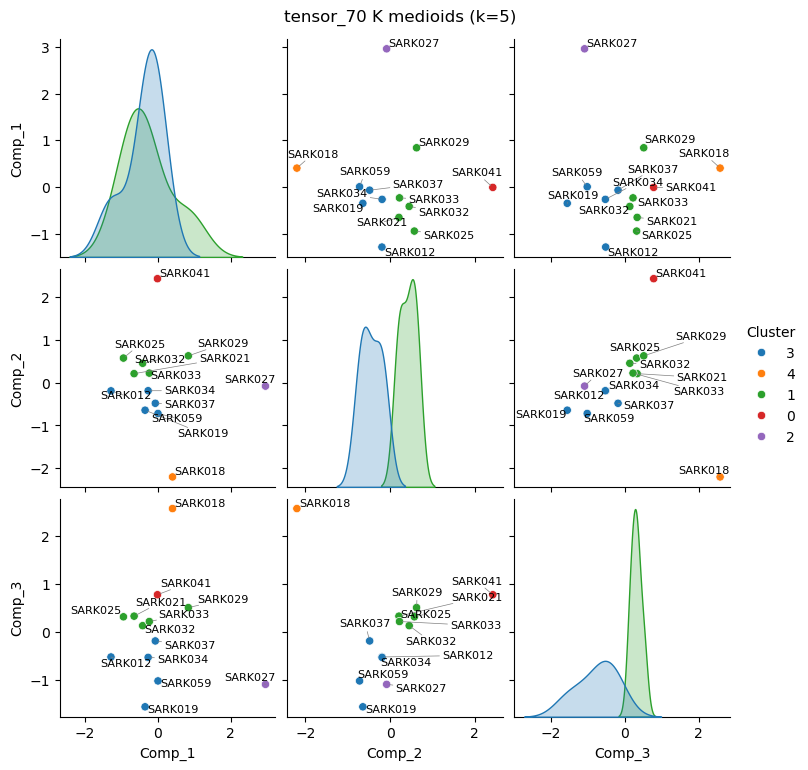

In [80]:
kmed_70 = run_clustering_pipeline_on_tensor('tensor_70', pat_list_70, normalize=True, n_clusters=n_clusters)

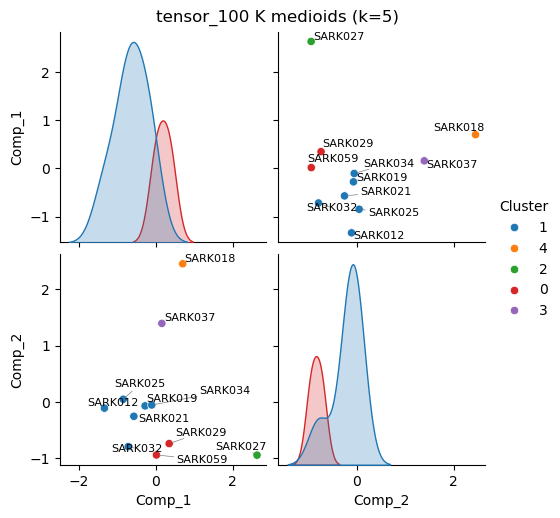

In [82]:
kmed_100 = run_clustering_pipeline_on_tensor('tensor_100', pat_list_100, normalize=True, n_clusters=n_clusters)

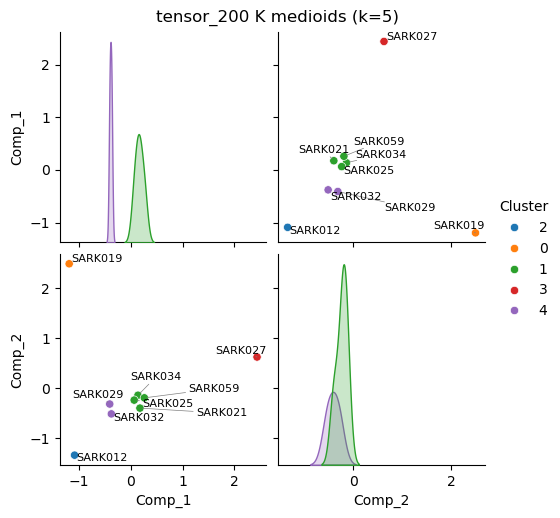

In [83]:
kmed_200 = run_clustering_pipeline_on_tensor('tensor_200', pat_list_200,  normalize=True, n_clusters=n_clusters)

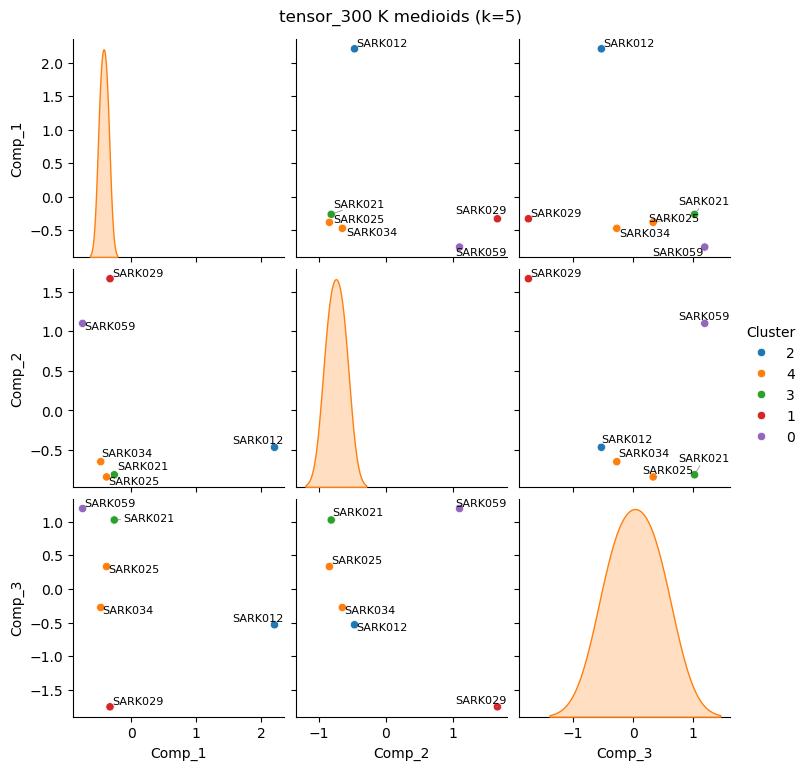

In [84]:
kmed_300 = run_clustering_pipeline_on_tensor('tensor_300', pat_list_300,normalize=True, n_clusters=n_clusters)